# Optimization using Grover/Durr Hoyer Algorithm

In [1]:
import qiskit
from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info import Operator
import numpy as np
import math
from math import *
import random

In [2]:
#define number of qubits (11 is the smallest number where the number of Durr-Hoyer iterations is smaller than the number of classical iterations 734 < 1024)
n=11

#create an identity matriz which will be changed depending of desired marked states
oracle_matrix = np.identity(2**n)

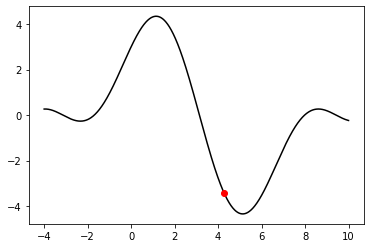

In [3]:
'''
Here, we will create an objective function f(x) such that we want to minimize. 
'''

x = np.linspace(-4,10,2**(n-1))
f_x = []

for i in range(2**(n - 1)):
    
    f = 2*sin(x[i]) + 3*cos(x[i]/2) #f(x) = 2sin(x) + 3cos(x/2)
    f_x.append(f)

    
# Pick a random index as our initial minimum threshold
y = random.randint(0, len(x))

# Plot the function to see what we're dealing with
import matplotlib.pyplot as plt
plt.plot(x, f_x, 'k', x[y], f_x[y], 'ro')

In [4]:
# Print the length of our "function" f_x. 
print(len(f_x))
# Note that the speed of the best classical algorithm scales linearly with the size of f_x

1024


## Grover's Algorithm

1) Create a list of $2^n$ integer numbers (states) in superposition $Y$: $H^{\otimes n}|0\rangle^{\otimes n}$

2) Mark elements with an oracle operator: an "identity" matrix where the desired states are multiplied by (-1)

3) Inversion about mean $W = 1 - |s\rangle \langle s| = \left(H^{\otimes n}U H^{\otimes n}\right)$ : increase the probability to measure the marked states. $U$ is an identity matrix where just the first element is -1.

4) Apply operators $\sqrt{\frac{32}{t}}$ times, where t is the number of desired states

5) Measurement



In [5]:
def grover_iterations(num_it):
    
    #define quantum circuits which will be used
    grover = QuantumCircuit(n,n-1)
    inv = QuantumCircuit(n,n-1)
    amp = QuantumCircuit(n,n-1)
    it = QuantumCircuit(n,n-1)
    
    
    '''
    By applying Hadamard gates to all qubits H^n|000..0>, we create a superposition of N=2^n states.
    Such states are represented in decimal basis as integer and positive numbers.
    Each eigenstate that compose the superposition is an element of space of models Y.
    '''
    grover.h(range(n)) #create space of models Y
    grover.barrier()


    def phase_inversion():
        
        '''
        Phase inversion operator, also called Oracle operator adds a phase of (-1) to the marked elements.
        Marked elements are what we are searching.
        
        Note that the amplitudes module |A| not change when we mark the states but the amplitudes average decrease.
        
        '''
        inv.unitary(Operator(oracle_matrix), range(n), label='invFase')
        inv.barrier()
        return inv

    def inv_about_mean():
        
        '''
        This operation (W = 1 - 2|s><s|) increase the probability to measure the desired states and decrease of the others.
        
        '''
        
        amp.h(range(n))
        amp.x(range(n))
        amp.h(0)
        targets = []
        for i in range(n-1):
          targets.append(i+1)
        amp.mct(targets,0)
        amp.h(0)
        amp.x(range(n))
        amp.h(range(n))
        amp.barrier()
        return amp

    it = phase_inversion() + inv_about_mean() # it is called grover's iteration

    for i in range(num_it):
        
        grover = grover.compose(it)


    grover.measure(range(n-1),range(n-1))
    
    
    
    return grover


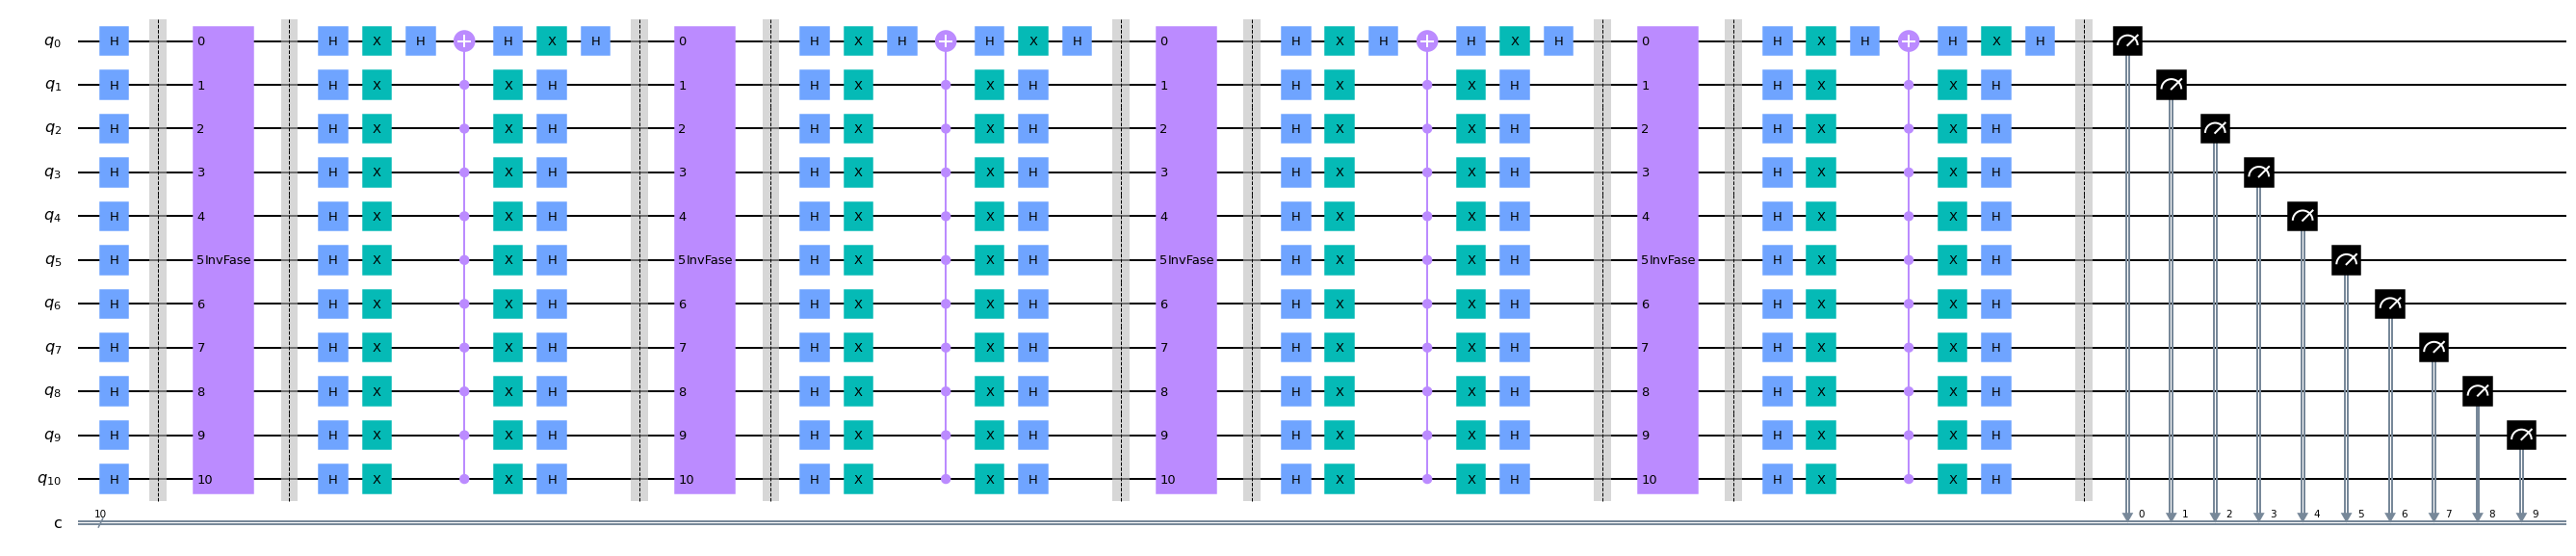

In [6]:
'''
Example in order to check if the function works well.

IMPORTANT: The number iterations depends of the number of desired (marked) states.

num_it = sqrt(2^n/t) where t is the number of desired states

'''

num_it=4
grover = grover_iterations(num_it)
grover.draw('mpl', fold=-1)

## Durr-Hoyer Algorithm to find a mininum

In [ ]:
calc_num_iterations = 22.5*np.sqrt(len(f_x)) + 1.4*np.log2(len(f_x))  # Max number of iterations allowed
print("The max number of iterations expected with Durr-Hoyer: {}".format(calc_num_iterations))

counted_num_iterations = 0  # How many iterations we actually go through

for k in range(int(calc_num_iterations)):
    
    '''
    Next, we create a list where will be stored the indexes that we will mark such that T[j] < T[y].
    
    '''

    index_to_mark = []
    for i in range(2**(n-1)):
        if (f_x[i] < f_x[y]):
            index_to_mark.append(i)

    '''
    Then, the algorithm change from 1 to -1 the correnpondent indexes of our identity matrix.
    '''
    
    oracle_matrix = np.identity(2**n)
    index = index_to_mark
    for j in index:
        oracle_matrix[j,j]=-1
        
    '''
    Here, we define num_it = sqrt(2^n/t) where t is len(index_to_mark)
    '''
       
    num_it = int(np.sqrt((2**(n-1)/(len(index_to_mark)+1))))
    grover = grover_iterations(num_it)            
    simulator = Aer.get_backend('qasm_simulator')
    
    '''
    take one shot. Probably the measured state will be one of the marked
    '''
    counts = execute(grover, backend=simulator, shots=1).result().get_counts(grover)

    '''
    binary to decimal basis
    '''
    for measured_value in counts:
        a=int(measured_value[::1], 2)
        
    '''
    compare if y'< y (according to durr-hoyer)
    
    if yes, then y = y'
    '''
    
    if (f_x[a] < f_x[y]):
        y=a
  
    print(y)
    print(index_to_mark)
    counted_num_iterations += 1
    
    '''
    if function have converged, then stop algorithm
    '''
    if (len(index_to_mark)==0):
        break
        
print("The total number of iterations actually ran: {}".format(counted_num_iterations))

The max number of iterations expected with Durr-Hoyer: 734.0
732
[605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735]
626
[608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662,

In [ ]:
'''
Here, we check what is our mininum f(xmin) 
'''

f_x[y]

In [ ]:
'''
Here, we check what is x that minimize f
'''

x[y]

In [ ]:
'''
Plot f(x) and the point (f(x), x) which is a mininum founded by durr-hoyer algorithm
'''

plt.plot(x, f_x, 'k', x[y], f_x[y], 'ro')
plt.ylabel('f(x)')
plt.xlabel('x')
plt.show()